In [1]:
# specify project directory in google drive
project_dir = '/content/drive/MyDrive/MyProjects/nature_multilabel_image_classification'

# prepared dataset
dataset_path = '/content/drive/MyDrive/MyProjects/nature_multilabel_image_classification/nature_data.npz'

# saved model name
model_name = 'best_vggblocks.h5'

# Nature Image Classification (Multi-labels)

## Objective 
To learn tags given to each image.  
There are 5 tags;  
- desert  
- mountains  
- sea  
- sunset  
- trees  

## Dataset
source : https://www.dropbox.com/s/0htmeoie69q650p/miml_dataset.zip?dl=0  
(You can follow the tutorial in this blog https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24)

## Approach
Baseline model : CNN model with 1,2 or 3 VGG block(s)  

Improved model 
- dropout
- data augmentation

## Load dataset from file

In [2]:
import numpy as np

In [3]:
# load data
data = np.load(dataset_path)
X, y = data['arr_0'], data['arr_1']
print('X shape : ', X.shape)
print('y shape : ', y.shape)

X shape :  (2000, 128, 128, 3)
y shape :  (2000, 5)


## Create train and test set
(Note : validation set will be created with ImageDataGenerator)

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [6]:
print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)
print()
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape :  (1600, 128, 128, 3)
y_train shape :  (1600, 5)

X_test shape :  (400, 128, 128, 3)
y_test shape :  (400, 5)


## Create data generator without data augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

## fbeta score function for multi-label problem

In [9]:
from tensorflow.keras import backend

# optional sklearn.metrics.fbeta_score (cannot be used as training metric)
#from sklearn.metrics import fbeta_score

In [10]:
# I create F-beta score calculation in Keras to use as a metric 
# during training process instead of accuracy.

def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

## Baseline Models

### Baseline model 1 : 1 vgg block

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
# create model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               13107300  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 13,117,949
Trainable params: 13,117,949
Non-trainable params: 0
____________________________________________

In [ ]:
# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

Epoch 1/200
64/64 [==============================] - 9s 23ms/step - loss: 3.8193 - fbeta: 0.3410 - val_loss: 0.4105 - val_fbeta: 0.4991
Epoch 2/200
64/64 [==============================] - 1s 17ms/step - loss: 0.3067 - fbeta: 0.6205 - val_loss: 0.4149 - val_fbeta: 0.4991
Epoch 3/200
64/64 [==============================] - 1s 17ms/step - loss: 0.1683 - fbeta: 0.8253 - val_loss: 0.4624 - val_fbeta: 0.5557
Epoch 4/200
64/64 [==============================] - 1s 17ms/step - loss: 0.0814 - fbeta: 0.9345 - val_loss: 0.6370 - val_fbeta: 0.5609
Epoch 5/200
64/64 [==============================] - 1s 19ms/step - loss: 0.0440 - fbeta: 0.9774 - val_loss: 0.5916 - val_fbeta: 0.6020
Epoch 6/200
64/64 [==============================] - 1s 17ms/step - loss: 0.0286 - fbeta: 0.9859 - val_loss: 0.8034 - val_fbeta: 0.5953
Epoch 7/200
64/64 [==============================] - 1s 18ms/step - loss: 0.0114 - fbeta: 0.9968 - val_loss: 0.7858 - val_fbeta: 0.5789
Epoch 8/200
64/64 [=============================

In [ ]:
# create function for plotting

def evaluate_model(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='val')
    plt.legend()
    plt.title('F-beta score')
    
    plt.show()
    
    # print model accuracy
    _, fbeta = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
    print('Model F-beta score : ', fbeta)
    return fbeta

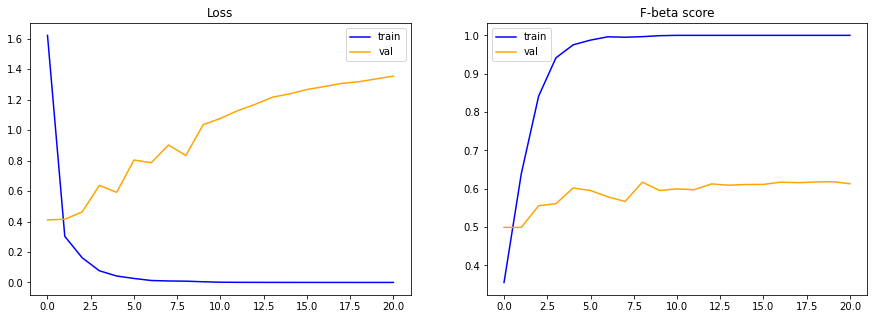

Model F-beta score :  0.6316560506820679


In [ ]:
baseline1_perf = evaluate_model(history)

Note : overfitting

### Baseline model 2 : 2 vgg blocks

Epoch 1/200
64/64 [==============================] - 2s 25ms/step - loss: 1.1420 - fbeta: 0.2742 - val_loss: 0.3872 - val_fbeta: 0.5678
Epoch 2/200
64/64 [==============================] - 1s 22ms/step - loss: 0.3351 - fbeta: 0.6308 - val_loss: 0.3780 - val_fbeta: 0.5718
Epoch 3/200
64/64 [==============================] - 1s 22ms/step - loss: 0.2823 - fbeta: 0.6786 - val_loss: 0.3941 - val_fbeta: 0.6161
Epoch 4/200
64/64 [==============================] - 1s 22ms/step - loss: 0.2027 - fbeta: 0.7799 - val_loss: 0.4327 - val_fbeta: 0.6266
Epoch 5/200
64/64 [==============================] - 2s 24ms/step - loss: 0.1168 - fbeta: 0.9092 - val_loss: 0.5253 - val_fbeta: 0.6453
Epoch 6/200
64/64 [==============================] - 1s 22ms/step - loss: 0.0812 - fbeta: 0.9313 - val_loss: 0.6902 - val_fbeta: 0.6545
Epoch 7/200
64/64 [==============================] - 1s 22ms/step - loss: 0.0403 - fbeta: 0.9689 - val_loss: 0.9465 - val_fbeta: 0.6319
Epoch 8/200
64/64 [=============================

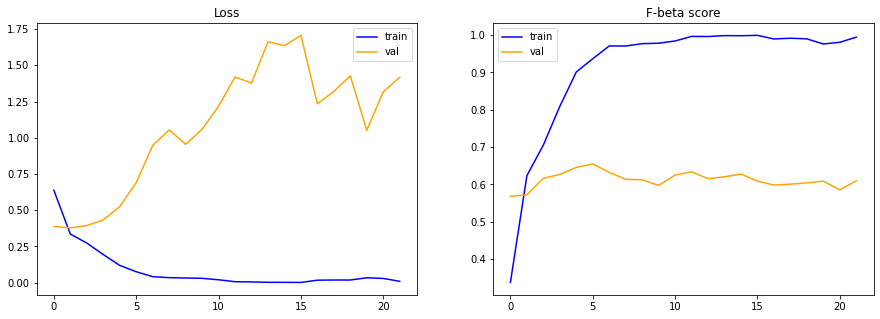

Model F-beta score :  0.638795018196106


In [ ]:
# create image data generator
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, seed=123)

# create model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)
# show result
baseline2_perf = evaluate_model(history)

Note : overfitting

### Baseline model 3 : 3 vgg blocks

Epoch 1/200
64/64 [==============================] - 3s 30ms/step - loss: 0.7400 - fbeta: 0.2580 - val_loss: 0.4249 - val_fbeta: 0.5544
Epoch 2/200
64/64 [==============================] - 2s 26ms/step - loss: 0.3706 - fbeta: 0.5673 - val_loss: 0.4277 - val_fbeta: 0.4741
Epoch 3/200
64/64 [==============================] - 2s 26ms/step - loss: 0.3249 - fbeta: 0.6218 - val_loss: 0.3657 - val_fbeta: 0.5777
Epoch 4/200
64/64 [==============================] - 2s 26ms/step - loss: 0.2837 - fbeta: 0.7151 - val_loss: 0.3994 - val_fbeta: 0.5887
Epoch 5/200
64/64 [==============================] - 2s 27ms/step - loss: 0.2472 - fbeta: 0.7507 - val_loss: 0.4056 - val_fbeta: 0.6202
Epoch 6/200
64/64 [==============================] - 2s 27ms/step - loss: 0.2023 - fbeta: 0.8093 - val_loss: 0.4701 - val_fbeta: 0.6548
Epoch 7/200
64/64 [==============================] - 2s 27ms/step - loss: 0.1584 - fbeta: 0.8506 - val_loss: 0.5121 - val_fbeta: 0.6665
Epoch 8/200
64/64 [=============================

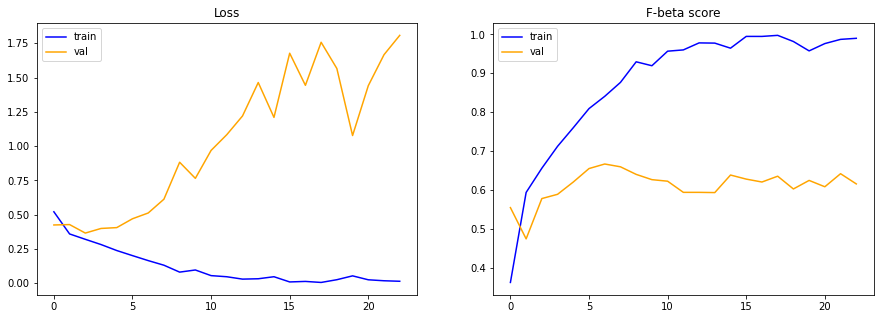

Model F-beta score :  0.6412715911865234


In [ ]:
# create model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)
# show result
baseline3_perf = evaluate_model(history)

Note : overfitting

## Baseline model performance


In [ ]:
print('Baseline model 1 : ', baseline1_perf)
print('Baseline model 2 : ', baseline2_perf)
print('Baseline model 3 : ', baseline3_perf)

Baseline model 1 :  0.6316560506820679
Baseline model 2 :  0.638795018196106
Baseline model 3 :  0.6412715911865234


## Improved Models

### model 1 : Baseline + dropout layers

Epoch 1/200
64/64 [==============================] - 3s 32ms/step - loss: 1.0503 - fbeta: 0.0906 - val_loss: 0.4268 - val_fbeta: 0.4541
Epoch 2/200
64/64 [==============================] - 2s 29ms/step - loss: 0.4069 - fbeta: 0.5306 - val_loss: 0.3837 - val_fbeta: 0.5637
Epoch 3/200
64/64 [==============================] - 2s 29ms/step - loss: 0.3696 - fbeta: 0.6001 - val_loss: 0.3975 - val_fbeta: 0.5208
Epoch 4/200
64/64 [==============================] - 2s 29ms/step - loss: 0.3647 - fbeta: 0.5942 - val_loss: 0.3803 - val_fbeta: 0.5902
Epoch 5/200
64/64 [==============================] - 2s 29ms/step - loss: 0.3216 - fbeta: 0.6763 - val_loss: 0.3421 - val_fbeta: 0.6385
Epoch 6/200
64/64 [==============================] - 2s 29ms/step - loss: 0.3102 - fbeta: 0.7010 - val_loss: 0.3669 - val_fbeta: 0.5970
Epoch 7/200
64/64 [==============================] - 2s 29ms/step - loss: 0.2807 - fbeta: 0.7330 - val_loss: 0.3758 - val_fbeta: 0.5673
Epoch 8/200
64/64 [=============================

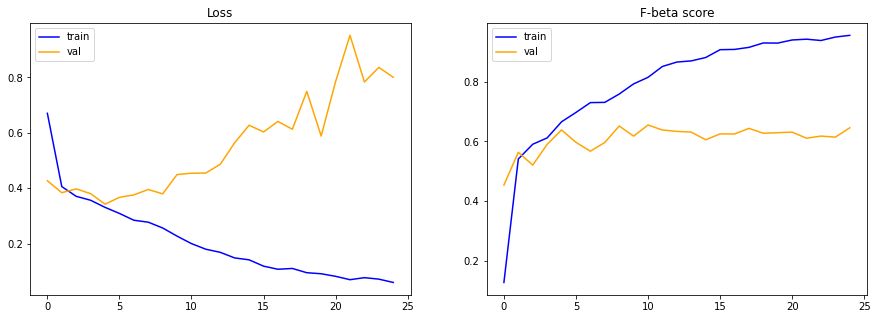

Model F-beta score :  0.6980035305023193


In [ ]:
# create image data generator
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='sigmoid'))


# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)
# show result
model1_perf = evaluate_model(history)

Note : overfitting is reduced

### model 2 : Baseline + data augmentation

Epoch 1/200
64/64 [==============================] - 7s 98ms/step - loss: 0.6678 - fbeta: 0.2235 - val_loss: 0.4323 - val_fbeta: 0.4469
Epoch 2/200
64/64 [==============================] - 6s 94ms/step - loss: 0.4165 - fbeta: 0.4209 - val_loss: 0.4362 - val_fbeta: 0.4350
Epoch 3/200
64/64 [==============================] - 6s 94ms/step - loss: 0.4034 - fbeta: 0.4537 - val_loss: 0.4170 - val_fbeta: 0.4916
Epoch 4/200
64/64 [==============================] - 6s 95ms/step - loss: 0.3779 - fbeta: 0.5227 - val_loss: 0.3860 - val_fbeta: 0.4904
Epoch 5/200
64/64 [==============================] - 6s 97ms/step - loss: 0.3672 - fbeta: 0.5340 - val_loss: 0.4132 - val_fbeta: 0.5166
Epoch 6/200
64/64 [==============================] - 6s 95ms/step - loss: 0.3447 - fbeta: 0.5777 - val_loss: 0.3871 - val_fbeta: 0.5418
Epoch 7/200
64/64 [==============================] - 6s 95ms/step - loss: 0.3474 - fbeta: 0.5786 - val_loss: 0.4215 - val_fbeta: 0.5614
Epoch 8/200
64/64 [=============================

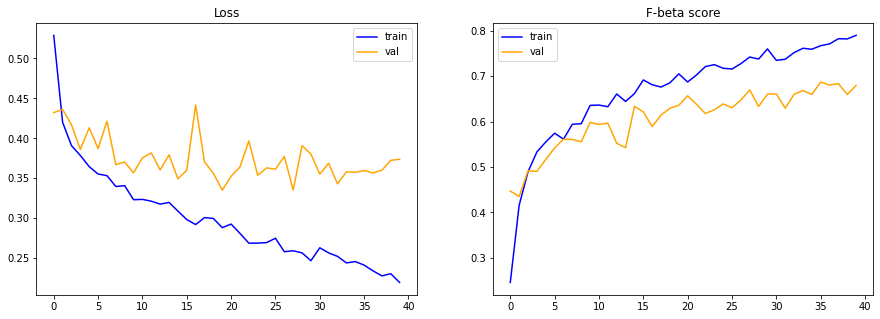

Model F-beta score :  0.7178556323051453


In [ ]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)
# show result
model2_perf = evaluate_model(history)

Note : overfitting is reduced

### model 3 : Baseline + data augmentation + dropout layers

Epoch 1/200
64/64 [==============================] - 7s 99ms/step - loss: 1.4335 - fbeta: 0.0607 - val_loss: 0.5784 - val_fbeta: 0.0000e+00
Epoch 2/200
64/64 [==============================] - 6s 95ms/step - loss: 0.5567 - fbeta: 0.0248 - val_loss: 0.5138 - val_fbeta: 0.2002
Epoch 3/200
64/64 [==============================] - 6s 95ms/step - loss: 0.4949 - fbeta: 0.2190 - val_loss: 0.4363 - val_fbeta: 0.3081
Epoch 4/200
64/64 [==============================] - 6s 95ms/step - loss: 0.4532 - fbeta: 0.3253 - val_loss: 0.4632 - val_fbeta: 0.3040
Epoch 5/200
64/64 [==============================] - 6s 95ms/step - loss: 0.4414 - fbeta: 0.3655 - val_loss: 0.4205 - val_fbeta: 0.3993
Epoch 6/200
64/64 [==============================] - 6s 95ms/step - loss: 0.4164 - fbeta: 0.4516 - val_loss: 0.4129 - val_fbeta: 0.3904
Epoch 7/200
64/64 [==============================] - 6s 95ms/step - loss: 0.4264 - fbeta: 0.4035 - val_loss: 0.4280 - val_fbeta: 0.4203
Epoch 8/200
64/64 [=========================

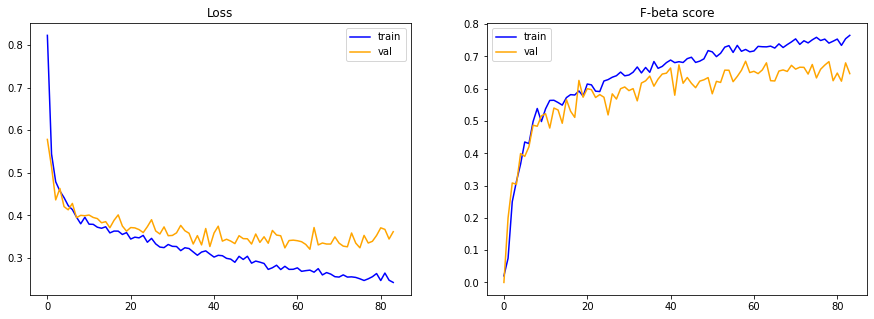

Model F-beta score :  0.7417535185813904


In [ ]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, seed=123)

# create model : add dropout layers
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)
# show result
model3_perf = evaluate_model(history)

Note : overfitting is reduced, the performance is lower

### model 4 : Baseline + data augmentation + dropout layer + more dense layers

Epoch 1/200
64/64 [==============================] - 7s 98ms/step - loss: 0.9555 - fbeta: 0.1117 - val_loss: 0.5111 - val_fbeta: 0.1496
Epoch 2/200
64/64 [==============================] - 6s 95ms/step - loss: 0.5103 - fbeta: 0.2377 - val_loss: 0.4578 - val_fbeta: 0.3296
Epoch 3/200
64/64 [==============================] - 6s 95ms/step - loss: 0.4674 - fbeta: 0.3119 - val_loss: 0.4529 - val_fbeta: 0.2850
Epoch 4/200
64/64 [==============================] - 6s 96ms/step - loss: 0.4590 - fbeta: 0.3346 - val_loss: 0.4374 - val_fbeta: 0.3153
Epoch 5/200
64/64 [==============================] - 6s 96ms/step - loss: 0.4391 - fbeta: 0.3520 - val_loss: 0.4145 - val_fbeta: 0.3774
Epoch 6/200
64/64 [==============================] - 6s 96ms/step - loss: 0.4223 - fbeta: 0.4056 - val_loss: 0.4246 - val_fbeta: 0.4239
Epoch 7/200
64/64 [==============================] - 6s 95ms/step - loss: 0.4044 - fbeta: 0.4224 - val_loss: 0.4322 - val_fbeta: 0.4244
Epoch 8/200
64/64 [=============================

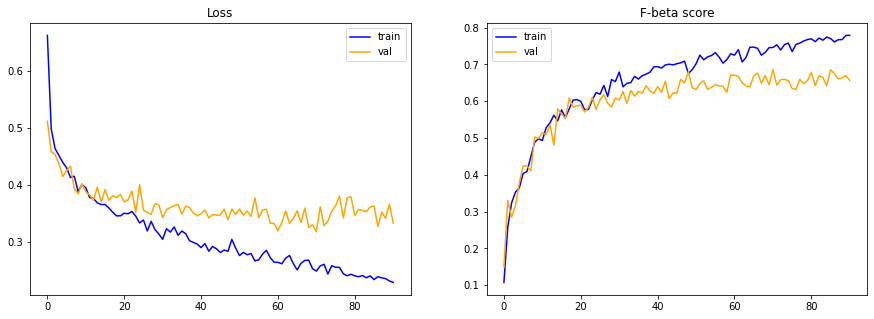

Model F-beta score :  0.7186980247497559


In [ ]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, seed=123)

# create model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(200, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='sigmoid'))


# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)
# show result
model4_perf = evaluate_model(history)

## Improved model performance (fbeta score)


In [ ]:
print('Baseline model : ', baseline3_perf)
print('Model 1 : ', model1_perf)
print('Model 2 : ', model2_perf)
print('Model 3 : ', model3_perf)
print('Model 4 : ', model4_perf)

Baseline model :  0.6412715911865234
Model 1 :  0.6980035305023193
Model 2 :  0.7178556323051453
Model 3 :  0.7417535185813904
Model 4 :  0.7186980247497559


## Finalize model 3
Train the selected model again.  
Give it more time to learn.  
Save the highest performance with ModelCheckpoint.

In [ ]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, seed=123)

# create model : add dropout layers
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint to save the model
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es, mc],
                    epochs=300)

Epoch 1/300
64/64 [==============================] - 14s 101ms/step - loss: 0.8874 - val_loss: 0.4946

Epoch 00001: val_loss improved from inf to 0.49458, saving model to best_vggblocks.h5
Epoch 2/300
64/64 [==============================] - 6s 97ms/step - loss: 0.4977 - val_loss: 0.4711

Epoch 00002: val_loss improved from 0.49458 to 0.47106, saving model to best_vggblocks.h5
Epoch 3/300
64/64 [==============================] - 6s 94ms/step - loss: 0.4718 - val_loss: 0.4598

Epoch 00003: val_loss improved from 0.47106 to 0.45982, saving model to best_vggblocks.h5
Epoch 4/300
64/64 [==============================] - 6s 95ms/step - loss: 0.4510 - val_loss: 0.4182

Epoch 00004: val_loss improved from 0.45982 to 0.41818, saving model to best_vggblocks.h5
Epoch 5/300
64/64 [==============================] - 6s 97ms/step - loss: 0.4361 - val_loss: 0.4124

Epoch 00005: val_loss improved from 0.41818 to 0.41244, saving model to best_vggblocks.h5
Epoch 6/300
64/64 [============================

## Evaluate model

In [ ]:
# print y_test
y_test[:5]

array([[0, 0, 0, 0, 1],
       [0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [14]:
# get y_pred
y_pred = model.predict(test_iter)
y_pred = y_pred.round()
print('y_pred shape : ', y_pred.shape)
print(y_pred[:5])

y_pred shape :  (400, 5)
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1.]]


In [15]:
# print model score
final_model_fbeta = fbeta(y_test, y_pred)
print('final_model_fbeta : ', final_model_fbeta.numpy())

final_model_fbeta :  0.72592944


In [ ]:
!ls

best_vggblocks.h5  drive  sample_data


In [ ]:
# copy saved model file to the project directory
import shutil
import os

shutil.copyfile(model_name, os.path.join(project_dir,model_name))

'/content/drive/MyDrive/MyProjects/nature_multilabel_image_classification/best_vggblocks.h5'